In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [3]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier

In [5]:
import xgboost as xgb

In [6]:
# !pip install xgboost

In [7]:
def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f"ML-datasets/{filename}.csv", index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes


def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'breast_cancer': {'class_column': 'Class', 'index_col': 'Sample code number'},
              'diabetes': {'class_column': 'Class', 'index_col': None}}
    dataset, classes = load_dataset(dataset_name, **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [8]:
X, y, classes = prepare_dataset('diabetes')

In [9]:
y.value_counts()

class
0    500
1    268
Name: count, dtype: int64

In [10]:
normalizer = Normalizer()
standarizer = StandardScaler()
preprocessor = standarizer

--------------------

## Testy na zbiorach danych

In [11]:
def preprocessor_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [12]:
def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

In [13]:
def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy: {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall: {metrics[2]}')
    print(f'  f1 score: {metrics[3]}')
    print(f'  Mislabeled: {metrics[4]}')
    print('\n')

In [14]:
def plot_confusion_matrix(confusion_matrix, classes, title=None, title_appendix='', cmap=plt.cm.Blues):
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'(Condusion matrix {title_appendix}'

    fig, ax = plt.subplots()
    img = ax.imshow(confusion_matrix, cmap=cmap)
    ax.figure.colorbar(img, ax=ax)
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                   ha = 'center', va='center',
                   color='white' if cell > thresh else 'black')

    fig.tight_layout()
    return ax

In [15]:
def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[np.newaxis].T

In [16]:
X, y, classes = prepare_dataset('wine')
X = preprocessor_data(X, standarizer)
X.describe()

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
print(y.value_counts)
print(y_train.value_counts)
print(y_test.value_counts)

<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
173    1
174    1
175    1
176    1
177    1
Name: class, Length: 178, dtype: int8>
<bound method IndexOpsMixin.value_counts of 87     2
26     0
2      0
36     0
102    2
      ..
148    1
59     2
64     2
34     0
103    2
Name: class, Length: 142, dtype: int8>
<bound method IndexOpsMixin.value_counts of 10     0
129    2
28     0
131    1
143    1
51     0
7      0
95     2
81     2
86     2
82     2
65     2
42     0
63     2
14     0
137    1
93     2
20     0
133    1
38     0
136    1
146    1
22     0
18     0
164    1
165    1
58     0
70     2
169    1
106    2
48     0
92     2
173    1
99     2
91     2
113    2
Name: class, dtype: int8>


In [19]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy: 0.9166666666666666
  Precision: 0.923076923076923
  Recall: 0.9246031746031745
  f1 score: 0.9229629629629629
  Mislabeled: 3




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

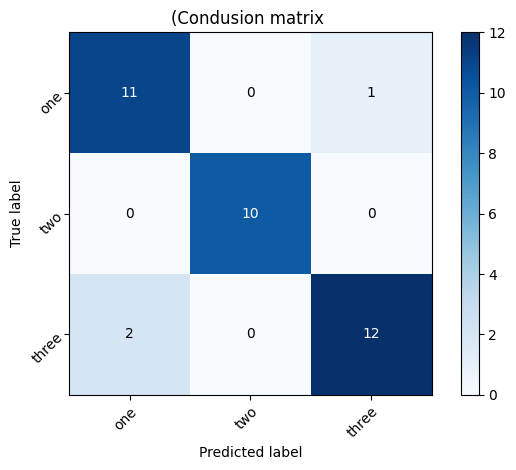

In [20]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

In [21]:
bclf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
bclf.fit(X_train, y_train)
y_b = bclf.predict(X_test)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Results for Bagging Ensamble
----
  Accuracy: 1.0
  Precision: 1.0
  Recall: 1.0
  f1 score: 1.0
  Mislabeled: 0




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

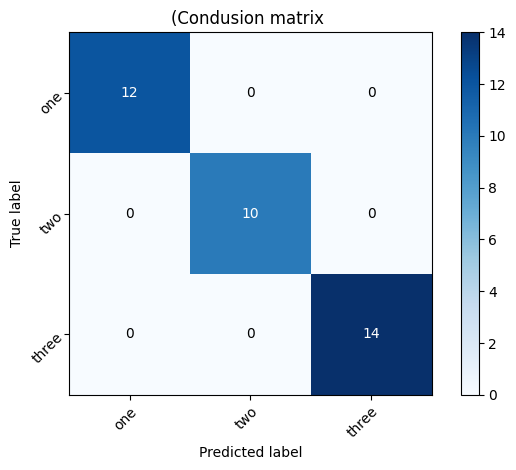

In [22]:
print_results(calculate_metrics(y_test.values, y_b), 'Bagging Ensamble')
cm = confusion_matrix(y_test, y_b)
plot_confusion_matrix(cm, classes)

In [23]:
bclf_svm = BaggingClassifier(base_estimator=SVC(C=100, kernel='poly'), n_estimators=50)
bclf_svm.fit(X_train, y_train)
y_b = bclf_svm.predict(X_test)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [24]:
print(bclf_svm.estimators_)

[SVC(C=100, kernel='poly', random_state=2064318369), SVC(C=100, kernel='poly', random_state=181689911), SVC(C=100, kernel='poly', random_state=1311626204), SVC(C=100, kernel='poly', random_state=1345246055), SVC(C=100, kernel='poly', random_state=1769006130), SVC(C=100, kernel='poly', random_state=482131902), SVC(C=100, kernel='poly', random_state=1192305783), SVC(C=100, kernel='poly', random_state=2124959017), SVC(C=100, kernel='poly', random_state=798137648), SVC(C=100, kernel='poly', random_state=1007492079), SVC(C=100, kernel='poly', random_state=975970992), SVC(C=100, kernel='poly', random_state=284301553), SVC(C=100, kernel='poly', random_state=2063060406), SVC(C=100, kernel='poly', random_state=1278164479), SVC(C=100, kernel='poly', random_state=1480472856), SVC(C=100, kernel='poly', random_state=659601927), SVC(C=100, kernel='poly', random_state=1719443551), SVC(C=100, kernel='poly', random_state=359322103), SVC(C=100, kernel='poly', random_state=1713487989), SVC(C=100, kernel=

Results for Bagging Ensamble
----
  Accuracy: 0.9444444444444444
  Precision: 0.9523809523809524
  Recall: 0.9523809523809524
  f1 score: 0.9487179487179486
  Mislabeled: 2




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

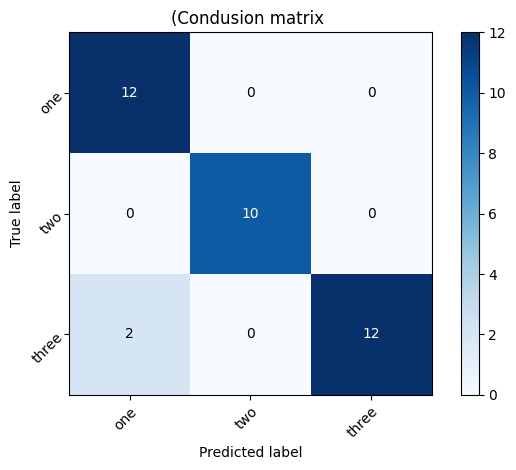

In [25]:
print_results(calculate_metrics(y_test.values, y_b), 'Bagging Ensamble')
cm = confusion_matrix(y_test, y_b)
plot_confusion_matrix(cm, classes)

In [26]:
def cross_validate1(classifier, kfold, X, y, classes, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))

    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        plot_confusion_matrix(normalize_confusion_matrix(cm), classes, title_appendix=clf.__class__.__name__)
        plt.show()
    else:
        return metrics, cm

In [27]:
cv_results = cross_validate(bclf, X, y, cv=10)
cv_results_tree = cross_validate(tree, X, y, cv=10)
cv_results_svm_bclf = cross_validate(bclf_svm, X, y, cv=10)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensembl

In [28]:
print(cv_results['test_score'])
print(cv_results_tree['test_score'])
print(cv_results_svm_bclf['test_score'])

[0.94444444 1.         0.83333333 0.94444444 0.94444444 1.
 1.         0.94444444 1.         1.        ]
[0.88888889 0.88888889 0.72222222 0.88888889 0.83333333 0.83333333
 1.         0.88888889 0.94117647 0.76470588]
[0.83333333 1.         0.94444444 1.         1.         1.
 1.         1.         1.         0.94117647]


Results for DecisionTreeClassifier
----
  Accuracy: 0.8707865168539326
  Precision: 0.8727754688832055
  Recall: 0.8724519906633775
  f1 score: 0.8718567439768995
  Mislabeled: 23




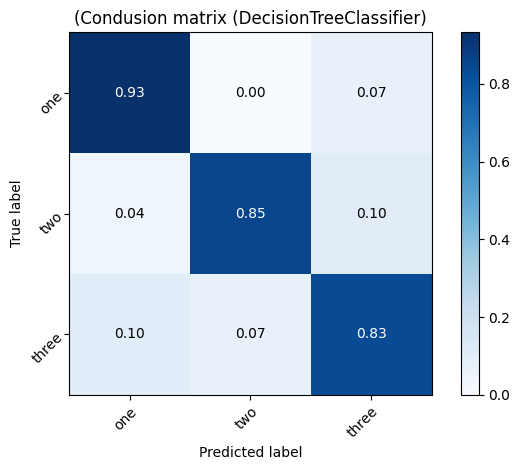

In [29]:
cross_validate1(DecisionTreeClassifier, StratifiedKFold(10), X, y, classes)

Results for BaggingClassifier
----
  Accuracy: 0.9438202247191011
  Precision: 0.9430382847791791
  Recall: 0.9479373889286756
  f1 score: 0.9451104451104451
  Mislabeled: 10




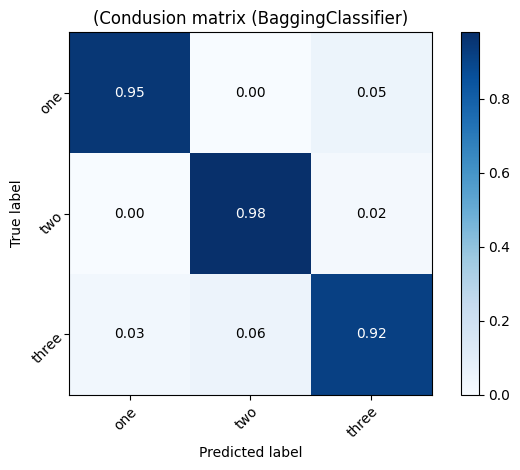

In [30]:
cross_validate1(BaggingClassifier, StratifiedKFold(10), X, y, classes)

In [31]:
X, y, classes = prepare_dataset('breast_cancer')

In [32]:
X['Bare Nuclei'] = X["Bare Nuclei"].replace('?', value=1)

In [33]:
X = preprocessor_data(X, standarizer)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

-----------

In [35]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy: 0.9285714285714286
  Precision: 0.9207427536231885
  Recall: 0.9207427536231885
  f1 score: 0.9207427536231885
  Mislabeled: 10




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

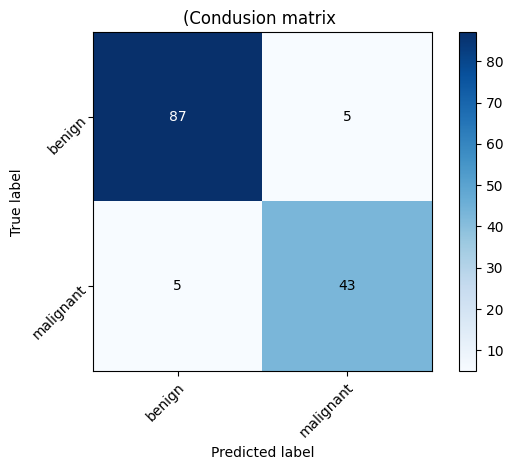

In [36]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

-----------------

In [37]:
bclf = BaggingClassifier(base_estimator=SVC())
bclf.fit(X_train, y_train)
y_bclf = bclf.predict(X_test)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Results for BaggingClassifier
----
  Accuracy: 0.9571428571428572
  Precision: 0.9524456521739131
  Recall: 0.9524456521739131
  f1 score: 0.9524456521739131
  Mislabeled: 6




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

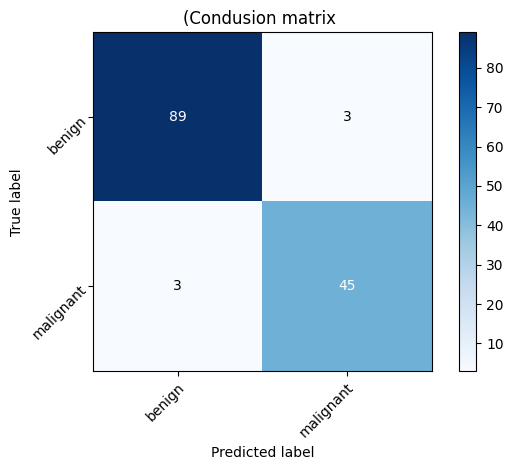

In [38]:
print_results(calculate_metrics(y_test.values, y_bclf), 'BaggingClassifier')
cm = confusion_matrix(y_test, y_bclf)
plot_confusion_matrix(cm, classes)

-----------------

In [39]:
cv_results = cross_validate(bclf, X, y, cv=10)
cv_results_tree = cross_validate(tree, X, y, cv=10)
# cv_results_svm_bclf = cross_validate(bclf_svm, X, y, cv=10)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensembl

In [40]:
print(cv_results['test_score'])
print(cv_results_tree['test_score'])

[0.9        0.97142857 0.97142857 0.91428571 1.         0.98571429
 0.97142857 1.         0.98571429 0.98550725]
[0.88571429 0.94285714 0.95714286 0.9        0.95714286 0.95714286
 0.94285714 0.97142857 0.95714286 0.97101449]


In [41]:
rfclf = RandomForestClassifier()

rfclf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
y_rf = rfclf.predict(X_test)

In [43]:
# print(rfclf.estimators_)

Results for RF Ensamble
----
  Accuracy: 0.9571428571428572
  Precision: 0.9524456521739131
  Recall: 0.9524456521739131
  f1 score: 0.9524456521739131
  Mislabeled: 6




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

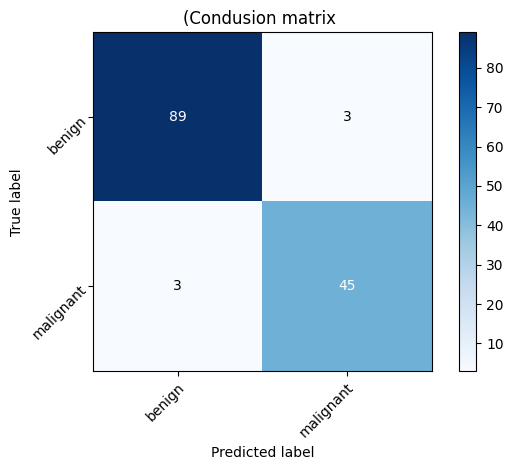

In [44]:
print_results(calculate_metrics(y_test.values, y_rf), 'RF Ensamble')
cm = confusion_matrix(y_test, y_rf)
plot_confusion_matrix(cm, classes)

Results for RandomForestClassifier
----
  Accuracy: 0.9628040057224606
  Precision: 0.9588369059051622
  Recall: 0.9588369059051622
  f1 score: 0.9588369059051622
  Mislabeled: 26




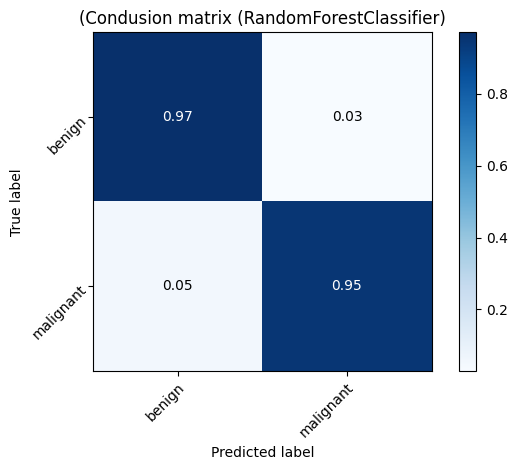

In [45]:
cross_validate1(RandomForestClassifier, StratifiedKFold(10), X, y, classes)

In [46]:
cross_validate_rf = cross_validate(rfclf, X, y, cv=10, scoring="f1_weighted")
np.mean(cross_validate_rf['test_score'])

0.9642421916573374

In [47]:
cross_validate_rf['test_score']

array([0.8994738 , 0.95639098, 0.97168254, 0.91563437, 0.98578157,
       0.98578157, 0.95639098, 0.98563911, 0.98564701, 1.        ])

--------------

In [48]:
X, y, classes = prepare_dataset('glass')
X = preprocessor_data(X, standarizer)
X.describe()

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02,2.140000e+02
mean,-2.877034e-14,2.191393e-15,-1.328117e-16,-2.988264e-16,9.525091e-16,3.527811e-17,-3.154278e-16,-6.640586e-17,-3.735330e-17
std,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00,1.002345e+00
min,-2.381516e+00,-3.286943e+00,-1.865511e+00,-2.318616e+00,-3.676472e+00,-7.639186e-01,-2.484084e+00,-3.528768e-01,-5.864509e-01
25%,-6.082728e-01,-6.141580e-01,-3.957744e-01,-5.117560e-01,-4.800288e-01,-5.756501e-01,-5.049657e-01,-3.528768e-01,-5.864509e-01
50%,-2.262293e-01,-1.323817e-01,5.527787e-01,-1.704602e-01,1.799655e-01,8.905322e-02,-2.514132e-01,-3.528768e-01,-5.864509e-01
75%,2.614331e-01,5.120326e-01,6.361680e-01,3.715977e-01,5.649621e-01,1.735820e-01,1.518057e-01,-3.528768e-01,4.422417e-01
max,5.137232e+00,4.875637e+00,1.254639e+00,4.125851e+00,3.570524e+00,8.780145e+00,5.094318e+00,5.997210e+00,4.659881e+00


In [49]:
y.value_counts()

class
1    76
0    70
3    29
5    17
2    13
4     9
Name: count, dtype: int64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [51]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=4, min_samples_leaf=3, criterion='entropy')
rf_model.fit(X_train, y_train)
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for RandomForestClassifier
----
  Accuracy: 0.7674418604651163
  Precision: 0.6865079365079366
  Recall: 0.7095238095238096
  f1 score: 0.6847701149425287
  Mislabeled: 10


Results for RandomForestClassifier_train
----
  Accuracy: 0.9122807017543859
  Precision: 0.9612223934257833
  Recall: 0.8850448019549945
  f1 score: 0.9118330268459691
  Mislabeled: 15




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

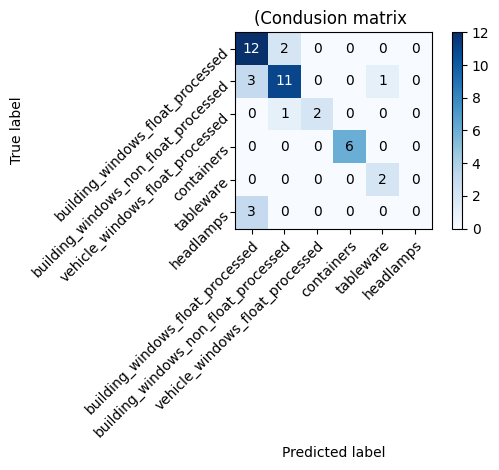

In [52]:
print_results(calculate_metrics(y_test.values, y_pred_test), 'RandomForestClassifier')
print_results(calculate_metrics(y_train.values, y_pred_train), 'RandomForestClassifier_train')
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, classes)

In [53]:
model_bclf = BaggingClassifier(base_estimator=SVC(C=10, gamma=0.01, kernel = 'rbf'), n_estimators=250)
model_bclf.fit(X_train, y_train)
y_test_bclf = model_bclf.predict(X_test)
y_train_bclf = model_bclf.predict(X_train)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [54]:
model_rfclf = RandomForestClassifier(n_estimators=250, max_depth=7, min_samples_split=4, min_samples_leaf=4, criterion='entropy')
model_rfclf.fit(X_train, y_train)
y_test_rfclf = model_rfclf.predict(X_test)
y_train_rfclf = model_rfclf.predict(X_train)

In [55]:
print_results(calculate_metrics(y_test.values, y_test_rfclf), 'RandomForestClassifier')
print_results(calculate_metrics(y_train.values, y_train_rfclf), 'RandomForestClassifier_train')

print_results(calculate_metrics(y_test.values, y_test_bclf), 'BaggingClassifie with SVMr')
print_results(calculate_metrics(y_train.values, y_train_bclf), 'BaggingClassifier_train with SVM')

Results for RandomForestClassifier
----
  Accuracy: 0.813953488372093
  Precision: 0.8718954248366013
  Recall: 0.7047619047619048
  f1 score: 0.7453405017921148
  Mislabeled: 8


Results for RandomForestClassifier_train
----
  Accuracy: 0.9239766081871345
  Precision: 0.9317685047193244
  Recall: 0.895167667922479
  f1 score: 0.9095383214235673
  Mislabeled: 13


Results for BaggingClassifie with SVMr
----
  Accuracy: 0.6744186046511628
  Precision: 0.5444444444444444
  Recall: 0.4746031746031745
  f1 score: 0.4792282430213464
  Mislabeled: 14


Results for BaggingClassifier_train with SVM
----
  Accuracy: 0.7485380116959064
  Precision: 0.6908068783068783
  Recall: 0.7192758714319655
  f1 score: 0.7025038043136514
  Mislabeled: 43




C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
abclf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5 ), n_estimators=50)
abclf.fit(X_train, y_train)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5))

In [57]:
y_ab =  abclf.predict(X_test)
y_ab_train =  abclf.predict(X_train)

Results for AdaBoost Ensamble
----
  Accuracy: 0.7441860465116279
  Precision: 0.6414565826330533
  Recall: 0.6261904761904762
  f1 score: 0.625981860186532
  Mislabeled: 11


Results for AdaBoost Ensamble train
----
  Accuracy: 1.0
  Precision: 1.0
  Recall: 1.0
  f1 score: 1.0
  Mislabeled: 0




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

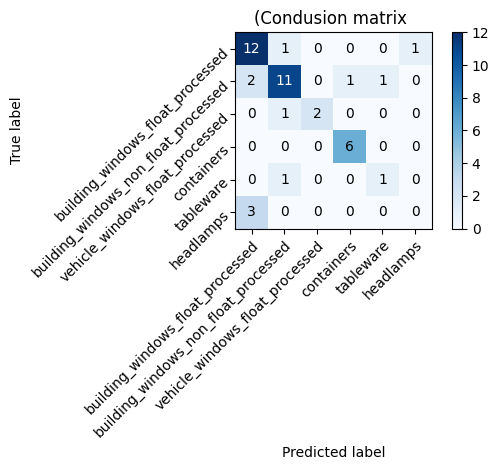

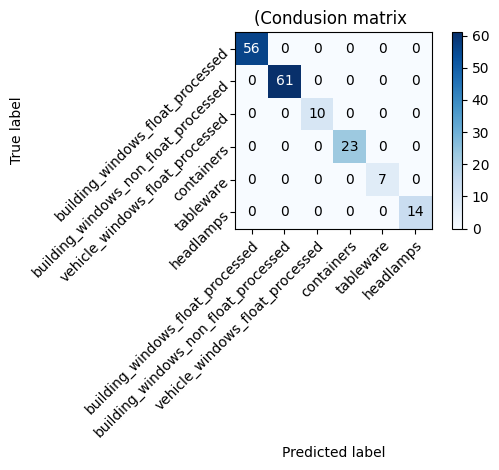

In [58]:
print_results(calculate_metrics(y_test.values, y_ab), 'AdaBoost Ensamble')
cm = confusion_matrix(y_test, y_ab)
plot_confusion_matrix(cm, classes)

print_results(calculate_metrics(y_train.values, y_ab_train), 'AdaBoost Ensamble train')
cm = confusion_matrix(y_train, y_ab_train)
plot_confusion_matrix(cm, classes)

In [59]:
cv_results = cross_validate(abclf, X, y, cv=10)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\ensem

In [60]:
np.mean(cv_results['test_score'])

0.7015151515151515

------------

### Adaboost i Bagging

In [61]:
gbclf = GradientBoostingClassifier(n_estimators=50)
gbclf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50)

In [62]:
y_gb = gbclf.predict(X_test)

Results for GradientBoost Ensamble
----
  Accuracy: 0.7674418604651163
  Precision: 0.70995115995116
  Recall: 0.7523809523809523
  f1 score: 0.7217473884140552
  Mislabeled: 10




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

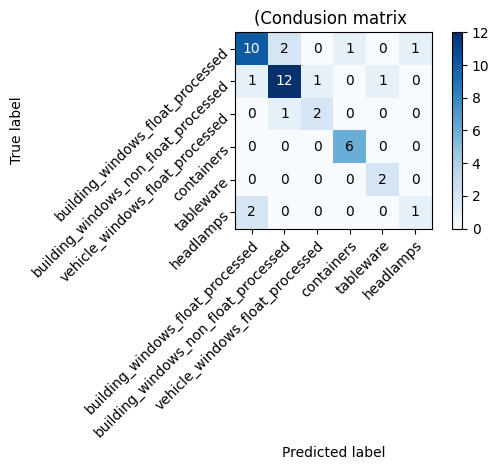

In [63]:
print_results(calculate_metrics(y_test.values, y_gb), 'GradientBoost Ensamble')
cm = confusion_matrix(y_test, y_gb)
plot_confusion_matrix(cm, classes)

In [64]:
cv_results = cross_validate(gbclf, X, y, cv=10)
np.mean(cv_results['test_score'])

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


0.6915584415584416

In [65]:
cv_results['test_score']

array([0.72727273, 0.59090909, 0.81818182, 0.63636364, 0.57142857,
       0.80952381, 0.80952381, 0.47619048, 0.66666667, 0.80952381])

--------

In [66]:
X, y, classes = prepare_dataset('glass')

In [67]:
X = preprocessor_data(X, standarizer)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [69]:
rfclf = RandomForestClassifier()
rfclf.fit(X_train, y_train)
y_rfclf = rfclf.predict(X_test)
# y_pred_train = rf_model.predict(X_train)

Results for RF Ensamble
----
  Accuracy: 0.7906976744186046
  Precision: 0.7605042016806722
  Recall: 0.6928571428571427
  f1 score: 0.7169632925472748
  Mislabeled: 9




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

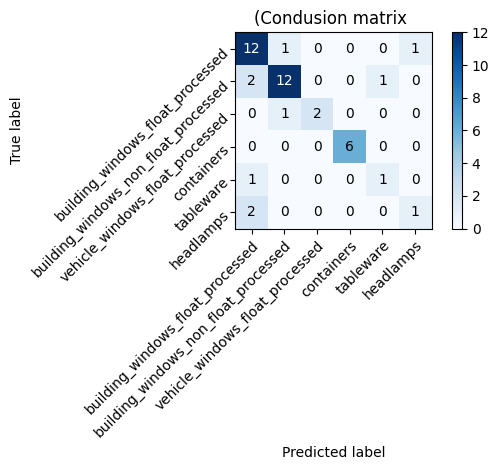

In [70]:
print_results(calculate_metrics(y_test.values, y_rfclf), 'RF Ensamble')
cm = confusion_matrix(y_test, y_rfclf)
plot_confusion_matrix(cm, classes)

In [71]:
cv_results = cross_validate(rfclf, X, y, cv=10)
cv_results['test_score']

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


array([0.68181818, 0.81818182, 0.81818182, 0.72727273, 0.71428571,
       0.85714286, 0.9047619 , 0.38095238, 0.80952381, 0.80952381])

In [72]:
gbclf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3)
gbclf.fit(X_train, y_train)
y_gbclf = gbclf.predict(X_test)

Results for RF Ensamble
----
  Accuracy: 0.7674418604651163
  Precision: 0.7116605616605617
  Recall: 0.753174603174603
  f1 score: 0.7223464275188413
  Mislabeled: 10




<Axes: title={'center': '(Condusion matrix '}, xlabel='Predicted label', ylabel='True label'>

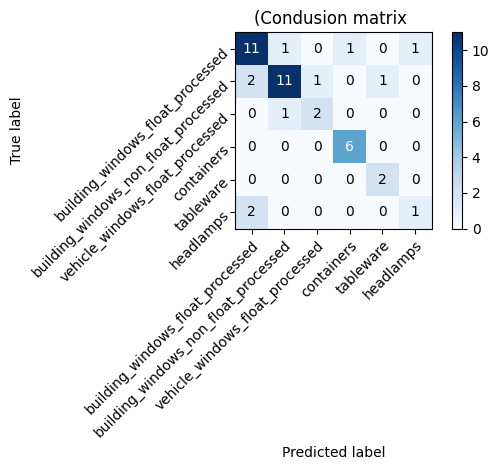

In [73]:
print_results(calculate_metrics(y_test.values, y_gbclf), 'RF Ensamble')
cm = confusion_matrix(y_test, y_gbclf)
plot_confusion_matrix(cm, classes)

In [74]:
cv_results = cross_validate(GradientBoostingClassifier(n_estimators=100), X, y, cv=9)
cv_results['test_score']

array([0.75      , 0.79166667, 0.75      , 0.70833333, 0.70833333,
       0.83333333, 0.45833333, 0.65217391, 0.73913043])

--------------

In [75]:
X, y, classes = prepare_dataset('diabetes')

In [76]:
X = preprocessor_data(X, standarizer)

C:\Users\AmanP\PycharmProjects\PodstawyPython\github\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [78]:
model_boosting  = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3)
model_boosting.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3)

In [79]:
y_pred_test = model_boosting.predict(X_test)
y_pred_train = model_boosting.predict(X_train)

In [80]:
print_results(calculate_metrics(y_test.values, y_pred_test), 'GradientBoostingClassifier_test')
print_results(calculate_metrics(y_train.values, y_pred_train), 'GradientBoostingClassifier_train')

Results for GradientBoostingClassifier_test
----
  Accuracy: 0.7532467532467533
  Precision: 0.729559748427673
  Recall: 0.7162962962962962
  f1 score: 0.7214924804873406
  Mislabeled: 38


Results for GradientBoostingClassifier_train
----
  Accuracy: 0.996742671009772
  Precision: 0.9975124378109452
  Recall: 0.9953271028037383
  f1 score: 0.9964056993666071
  Mislabeled: 2




In [81]:
y.value_counts()

class
0    500
1    268
Name: count, dtype: int64

In [83]:
X.describe()

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-6.476301e-17,-9.251859e-18,1.503427e-17,1.006140e-16,-3.006854e-17,2.590520e-16,2.451743e-16,1.931325e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-3.783654e+00,-3.572597e+00,-1.288212e+00,-6.928906e-01,-4.060474e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-6.852363e-01,-3.673367e-01,-1.288212e+00,-6.928906e-01,-5.955785e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.218877e-01,1.496408e-01,1.545332e-01,-4.280622e-01,9.419788e-04,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.057709e-01,5.632228e-01,7.190857e-01,4.120079e-01,5.847705e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.444478e+00,2.734528e+00,4.921866e+00,6.652839e+00,4.455807e+00,5.883565e+00,4.063716e+00


------------------

---------------

# 9_2

-----

In [ ]:
model = xgb.XGBClassifier(eta=0.01, n_est)